# Prova

In [1]:
import matplotlib.pyplot as plt
from mcmc_plots import (plot_trace_mcmc, plot_marginal_distributions, 
                       plot_autocorrelations, plot_distribution)
%load_ext autoreload
%autoreload 2

In [2]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

plt.rcParams['patch.edgecolor'] = 'black'

In [3]:
import numpy as np
from scipy.special import logsumexp

# -----------------------------
# Log-sigma parametrization:
# theta = [w, mu1, delta, ls1, ls2]  where ls = log(sigma)
# -----------------------------

def log_prior(theta, bounds):
    """
    Uniform prior inside the bounds (applied on ls = log(sigma))
    theta: [w, mu1, delta, ls1, ls2]
    bounds: [[w_min,w_max], [mu1_min,mu1_max], [delta_min,delta_max],
             [ls1_min, ls1_max], [ls2_min, ls2_max]]
    """
    theta = np.atleast_1d(theta)
    for i in range(theta.shape[0]):
        if theta[i] < bounds[i][0] or theta[i] > bounds[i][1]:
            return -np.inf
    return 0.0    

def log_T90_distribution(x, theta, sigma_logT90 = 0.0):
    """
    Parametri:
    - x: dati log(T90) (logaritmo naturale)
    - theta: [w, mu1, delta, ls1, ls2] where ls = log(sigma)
    - sigma_logT90: eventuale errore gaussiano su log(T90)
    """
    w, mu1, delta, ls1, ls2 = theta
    # transform
    sigma1 = np.exp(ls1)
    sigma2 = np.exp(ls2)

    # validity checks
    if (sigma1 <= 0) or (sigma2 <= 0) or (w <= 0) or (w >= 1) or (delta < 0):
        return -np.inf

    mu2    = mu1 + delta
    var1   = sigma1**2 + sigma_logT90**2
    var2   = sigma2**2 + sigma_logT90**2

    logN1 = -0.5*(np.log(2*np.pi*var1) + ((x-mu1)**2)/var1)
    logN2 = -0.5*(np.log(2*np.pi*var2) + ((x-mu2)**2)/var2)
    stacked = np.vstack([np.log(w) + logN1, np.log(1-w) + logN2]) 
    return logsumexp(stacked, axis=0)     

def log_likelihood(x, theta, sigma_logT90 = 0.0):
    return np.sum(log_T90_distribution(x, theta, sigma_logT90), axis=0)

def proposal_distribution(x,  rng = None):
    """
    Keeps your adaptive covariance matrix; expects x (or theta0) as input
    and uses its dimension to draw a multivariate normal increment.
    """
    d = x.shape[0]

    covariance = np.array(([ 1.16001274e-04, 4.34444634e-05, -8.75870281e-06, 3.74859215e-05, -2.68890398e-05],
                           [ 4.34444634e-05, 1.30336403e-03, -1.12672730e-03, 2.51966524e-04, -1.73614797e-04],
                           [-8.75870281e-06, -1.12672730e-03, 1.90314140e-03, -9.62649007e-05, 8.67849825e-06],
                           [ 3.74859215e-05, 2.51966524e-04, -9.62649007e-05, 8.14646898e-04, -1.35645581e-04],
                           [-2.68890398e-05, -1.73614797e-04, 8.67849825e-06, -1.35645581e-04, 5.28118669e-04]))
    if rng is None:
        rng = np.random
    return rng.multivariate_normal(np.zeros(d,dtype=np.float64), covariance)

def log_posterior(x, theta, bounds, sigma_logT90 = 0.0):
    return log_prior(theta, bounds) + log_likelihood(x, theta, sigma_logT90 = sigma_logT90)
    
def generate_data(theta_true, N, rng = None, sigma_logT90 = 1.0):
    """
    theta_true uses 'sigma1' and 'sigma2' in linear space (not log)
    returns logT90 samples (same as before)
    """
    if rng is None:
        rng = np.random

    z = rng.random(N) < theta_true["w"] 
    logT90_gen = np.where(z, 
                rng.normal(theta_true["mu1"], theta_true["sigma1"], size=N),
                rng.normal(theta_true["mu2"], theta_true["sigma2"], size=N))

    return logT90_gen + rng.normal(0.0, sigma_logT90, size=N)

def metropolis_hastings(theta0, x, bounds, rng = None, sigma_logT90 = 0.0, n = 1000):
    if rng is None:
        rng = np.random
    
    accepted = 0
    rejected = 1
    
    theta0 = np.atleast_1d(theta0)
    d = theta0.shape[0]
    
    logP0   = log_posterior(x, theta0, bounds, sigma_logT90 = sigma_logT90)
    samples = np.zeros((n,d), dtype=np.float64)
    
    for i in range(n):
        theta_t = theta0 + proposal_distribution(theta0, rng = rng)
        logP_t = log_posterior(x, theta_t, bounds, sigma_logT90 = sigma_logT90)
        
        if logP_t - logP0 > np.log(rng.uniform(0,1)):
            theta0       = theta_t
            logP0        = logP_t
            samples[i,:] = theta_t
            accepted    += 1
        else:
            samples[i,:] = theta0
            rejected    += 1
        
        # ridotta verbosità consigliata, ma lascio la tua stampa (puoi commentarla)
        print("iteration {0}: acceptance {1}".format(i,accepted/float(accepted+rejected)))
    overall_rate = accepted / float(n)
    print("Adaptive Metropolis finished. Acceptance rate = {:.4f}".format(overall_rate))
    
    return samples

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorrelation(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n
    if norm:
        acf /= acf[0]
    return acf

def init_theta_from_data(x, bounds, rng=None):
    """
    Initialize theta0 using percentili etc. but in log-sigma space
    theta = [w, mu1, delta, ls1, ls2]
    """
    if rng is None:
        rng = np.random.default_rng()
    # percentili utili
    p25 = np.percentile(x, 25)
    p75 = np.percentile(x, 75)
    mu1_0 = p25
    delta_0 = max(0.5, p75 - p25)   # almeno 0.5
    w0 = 0.5
    s1_0 = 1.0
    s2_0 = 1.0
    ls1_0 = np.log(s1_0)
    ls2_0 = np.log(s2_0)
    # clip to bounds
    theta0 = np.array([np.clip(w0, bounds[0][0]+1e-12, bounds[0][1]-1e-12),
                       np.clip(mu1_0, bounds[1][0], bounds[1][1]),
                       np.clip(delta_0, bounds[2][0]+1e-12, bounds[2][1]),
                       np.clip(ls1_0, bounds[3][0], bounds[3][1]),
                       np.clip(ls2_0, bounds[4][0], bounds[4][1])], dtype=np.float64)
    return theta0

In [4]:
DATA_PATH = "GRBs/GRB_data.txt"
arr = np.loadtxt(DATA_PATH, skiprows=1)

In [5]:
# -------------------------
# Main script usage (example)
# -------------------------
LOAD = False
rng = np.random.default_rng(1234)

logT90       = arr[:,0]   # your observed ln(T90)
sigma_logT90 = arr[:,1]

# True params for simulation (sigma in linear space)
theta_true = {"w": 0.3, "mu1": -0.5, "mu2": 3.5, "sigma1": 0.8, "sigma2": 1.0}
logT90 = generate_data(theta_true, N = len(logT90), rng=rng, sigma_logT90=sigma_logT90)

# theta_sim must be in the new parameterization (use log(sigma))
theta_sim = np.array((theta_true['w'], 
                      theta_true['mu1'], 
                      theta_true['mu2']-theta_true['mu1'], 
                      np.log(theta_true['sigma1']),
                      np.log(theta_true['sigma2']))) 

print('logL (simulation)= ', log_likelihood(logT90, theta_sim, sigma_logT90))

# define the prior bounds ON the transformed parameters (ls = log(sigma))
bounds = [
    [0.0, 1.0],                 # w
    [-4.0, 7.0],                # mu1 (ln s)
    [0.0, 10.0],                # delta = mu2 - mu1
    [np.log(1e-1), np.log(6.0)],# ls1 bounds (log-scale of sigma1)
    [np.log(1e-1), np.log(6.0)] # ls2 bounds
]

# run the mh sampler
n_steps  = 50000

if LOAD == 0:
    theta0  = init_theta_from_data(logT90, bounds, rng)
    samples = metropolis_hastings(theta0, logT90, bounds, rng = rng, 
                                  sigma_logT90 = 0.0, n = n_steps)
    #np.savetxt('chain.txt',samples)
else:
    samples = np.loadtxt('chain.txt')

logL (simulation)=  -3730.0687128964673
iteration 0: acceptance 0.5
iteration 1: acceptance 0.3333333333333333
iteration 2: acceptance 0.25
iteration 3: acceptance 0.2
iteration 4: acceptance 0.16666666666666666
iteration 5: acceptance 0.14285714285714285
iteration 6: acceptance 0.125
iteration 7: acceptance 0.2222222222222222
iteration 8: acceptance 0.3
iteration 9: acceptance 0.36363636363636365
iteration 10: acceptance 0.4166666666666667
iteration 11: acceptance 0.46153846153846156
iteration 12: acceptance 0.5
iteration 13: acceptance 0.5333333333333333
iteration 14: acceptance 0.5
iteration 15: acceptance 0.47058823529411764
iteration 16: acceptance 0.4444444444444444
iteration 17: acceptance 0.42105263157894735
iteration 18: acceptance 0.45
iteration 19: acceptance 0.42857142857142855
iteration 20: acceptance 0.45454545454545453
iteration 21: acceptance 0.43478260869565216
iteration 22: acceptance 0.4583333333333333
iteration 23: acceptance 0.44
iteration 24: acceptance 0.42307692

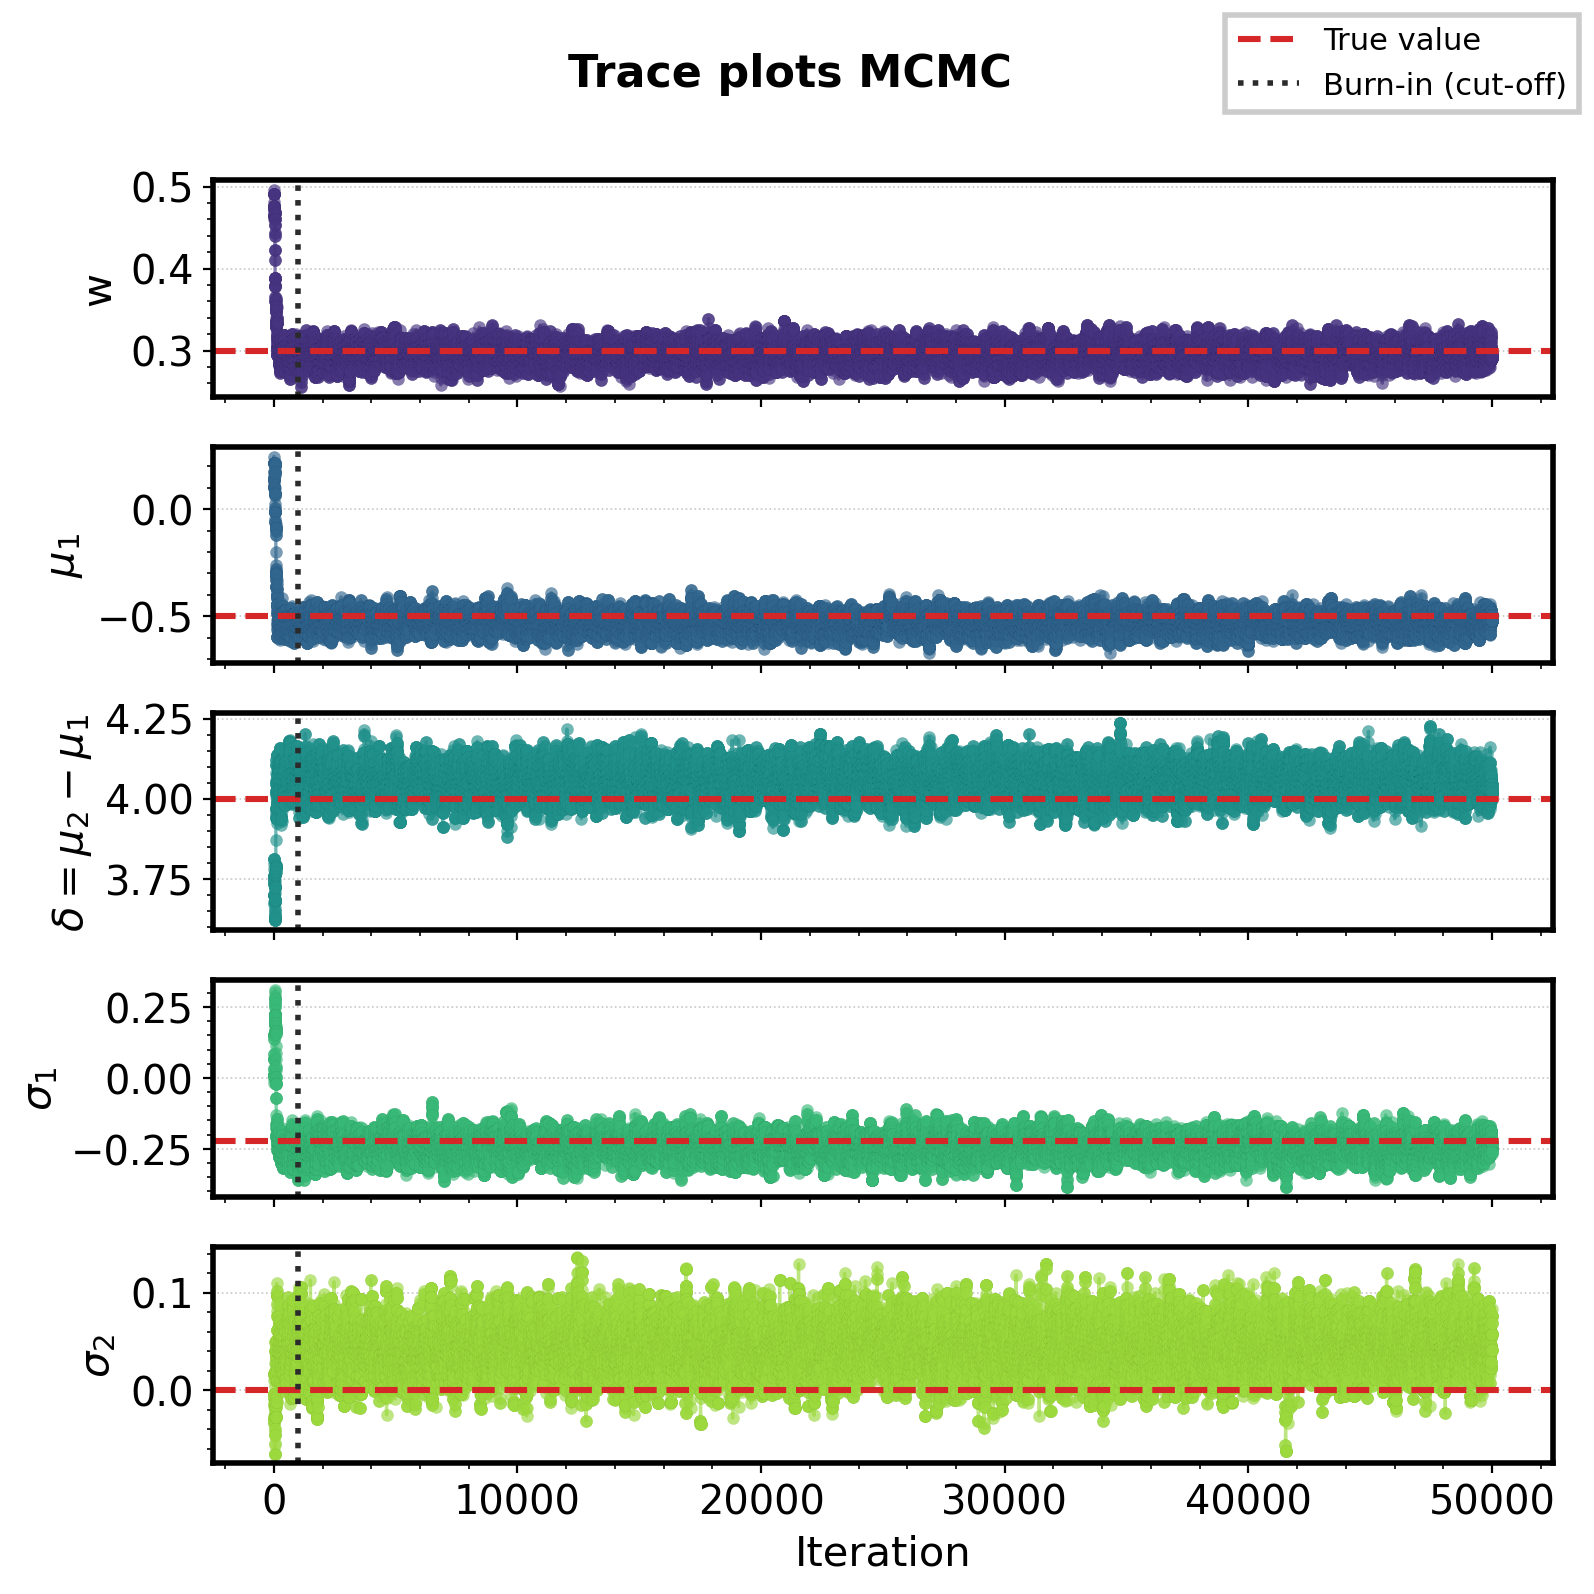

In [6]:
filename = 'trace_plot_mcmc_after_adaptive'
fig, axes = plot_trace_mcmc(samples, filename, theta_sim, burnin=1000, save=False)

In [7]:
burnin = 1000

samples_new = samples[burnin:,:]

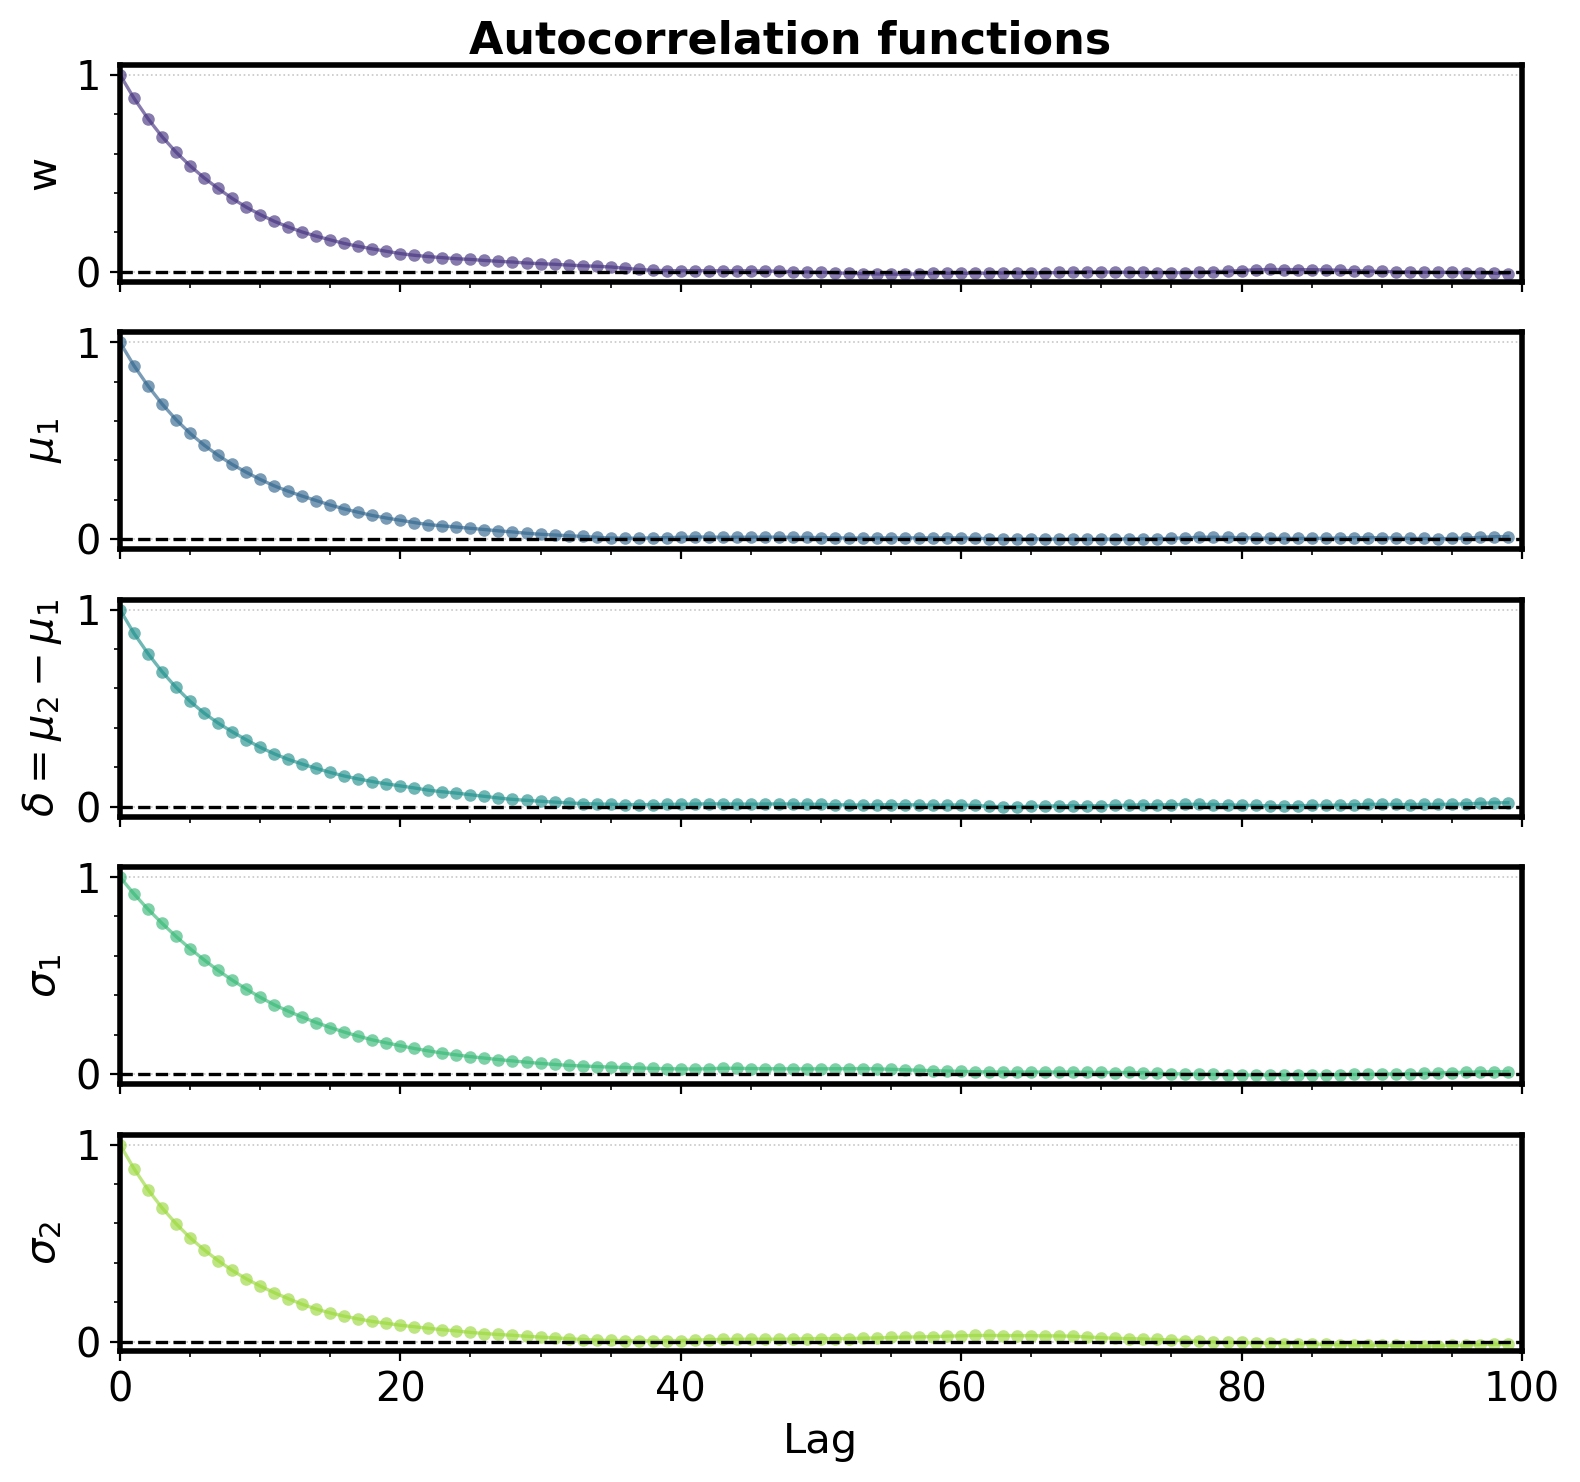

In [8]:
filename = 'autocorrelation_mcmc_after_adaptive'
fig3, axes3 = plot_autocorrelations(samples_new, filename, max_lag=100, save=False)

In [9]:
def autocorr(x, lag):
    return np.corrcoef(np.array([x[:-lag], x[lag:]]))[0,1]

def ess(x):
    n = len(x)
    # calcolo autocorrelazione fino a quando diventa negativa
    rho = []
    for k in range(1, n//2):
        r = autocorr(x, k)
        if r <= 0: 
            break
        rho.append(r)
    tau = 1 + 2*np.sum(rho)
    return n / tau

In [10]:
for i, key in enumerate(theta_true.keys()):
    print(f'N_ESS ({key}) = {ess(samples_new[:,i]):.0f}')

N_ESS (w) = 2939
N_ESS (mu1) = 2900
N_ESS (mu2) = 2587
N_ESS (sigma1) = 2231
N_ESS (sigma2) = 2877


In [11]:
thinning = 25
samples_new = samples_new[::thinning,:]

In [12]:
samples_new.shape

(1960, 5)

/home/leo/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


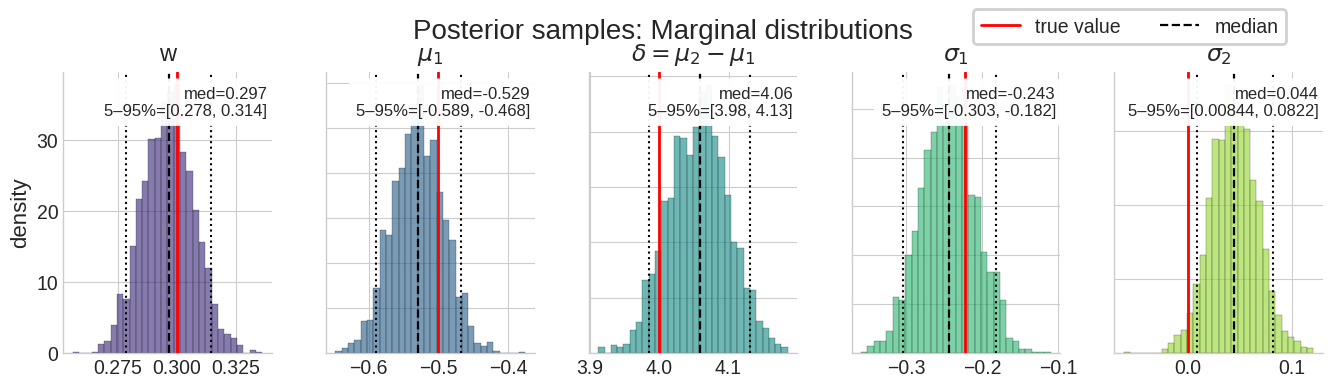

In [13]:
filename = 'marginal_distribution_mcmc_after_adaptive'
fig2, axes2 = plot_marginal_distributions(samples_new, filename, theta_sim, save=False)

In [14]:
filename = 'distribution_mcmc_after_adaptive'
fig4, axes4 = plot_distribution(logT90, samples_new, filename, theta_true=theta_sim, save=False)

IndexError: index 60 is out of bounds for axis 0 with size 1